**Clasificador de sentimientos**

#Machine Learning classic (LogisticRegression)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

##P0.descargando librerias

---
*   https://stackabuse.com/python-for-nlp-introduction-to-the-pattern-library/




In [14]:
!pip install pyprind

In [15]:
import nltk
nltk.download('stopwords') #Descargamos la lista de StopWord (pronombres, artículos, condicionales, demostrativos, adverbios de tiempo y lugar)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
!pip install pattern  #libreria para PLN (Tokenización, derivación, etiquetado de POS, análisis de sentimientos, etc)

##P1.Importando librerias

###P1.1 Genericas

In [17]:
import urllib.request
import numpy as np
import pandas as pd 
import os
import time
import sys
from zipfile import ZipFile       #para descomprimir ZIP
#-----librerias para trabajar PLN
import nltk
#from pattern.es import lemma
from nltk import word_tokenize
from nltk.corpus import stopwords

#----librerias para normalización de textos
import re
from unicodedata import normalize

###P1.2 Machine Learning

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#CountVectorizer proporcionado por la biblioteca scikit-learn para vectorizar oraciones.
from sklearn.feature_extraction.text import CountVectorizer

##P2. descargando DataSet

In [19]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurrido" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()

url_github_Model='https://github.com/alixchaparrov/deeplearning/blob/main/P2T7_Signos_Zodiaco.zip?raw=true'
urllib.request.urlretrieve(url_github_Model,
                           'P2T7_Signos_Zodiaco.zip', 
                           reporthook)

101% | 0 MB | 1.23 MB/s | 0 segundos transcurrido

('P2T7_Signos_Zodiaco.zip', <http.client.HTTPMessage at 0x7efe5777b950>)

##P3.descomprimir Zip y cargar en Dataframe

###P3.1 descomprimir ZIP

In [20]:
test_file_name = "/content/P2T7_Signos_Zodiaco.zip"

with ZipFile(test_file_name, 'r') as zip:
    zip.printdir()
    zip.extractall('P2T7_Signos_Zodiaco') 

File Name                                             Modified             Size
Signos_Zodiaco/Aries.csv                       2022-05-18 12:19:36       276499
Signos_Zodiaco/Cancer.csv                      2022-05-18 13:49:54        92314
Signos_Zodiaco/Geminis.csv                     2022-05-18 13:26:32       275541
Signos_Zodiaco/Tauro.csv                       2022-05-18 13:17:46       261004


###P3.2 carga los CSV en Dataframe

In [24]:
filepath_dict = {'Aries':   '/content/Signos_Zodiaco/Aries.csv',
                 'Cancer': '/content/Signos_Zodiaco/Cancer.csv',
                 'Geminis':   '/content/Signos_Zodiaco/Geminis.csv',
                 'Tauro':   '/content/Signos_Zodiaco/Tauro.csv',}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['full_text', 'reply_count', 'retweet_count', 'favorite_count', 'url', 'created_at'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(10)

FileNotFoundError: ignored

##P4. conociendo la data (BagWord)

In [25]:
print('RowsXcolums-->',df.shape)
print('Aries-->',sum(df['source'] == 'Aries'))
print('Cancer-->',sum(df['source'] == 'Cancer'))
print('Geminis-->',sum(df['source'] == 'Geminis'))
print('Tauro-->',sum(df['source'] == 'Tauro'))

NameError: ignored

###P4.1 usando CountVectorizer (ejemplo)

---

CountVectorizer proporcionado por la biblioteca scikit-learn  realiza la tokenización que separa las oraciones en un conjunto de tokens ordenado por vocabulario. Además, elimina la puntuación y los caracteres especiales y puede aplicar otro preprocesamiento a cada palabra

In [26]:
#obtener las palabras que aparecen de acuerdo con el Orden del vocabulario
oraciones = ['Cuando Aries empieza el día con mal pie es mal asunto para todos los que tienen cerca y es que no tienen miramientos a la hora de soltar lo primero que le viene a la mente', 'Es quien te dedica su tiempo, quiere escuchar todo lo que sale de tu boca, se pone feliz al verte y parece no aburrirse de tu compañía']
vectorizer = CountVectorizer(min_df=0, lowercase=True,stop_words=stopwords.words('spanish'))   
     
vectorizer.fit(oraciones)

CountVectorizer(min_df=0,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...])

In [27]:
vectorizer.get_feature_names_out()

array(['aburrirse', 'aries', 'asunto', 'boca', 'cerca', 'compañía',
       'dedica', 'día', 'empieza', 'escuchar', 'feliz', 'hora', 'mal',
       'mente', 'miramientos', 'parece', 'pie', 'pone', 'primero',
       'quiere', 'sale', 'soltar', 'tiempo', 'verte', 'viene'],
      dtype=object)

In [28]:
vectorizer.vocabulary_

{'aburrirse': 0,
 'aries': 1,
 'asunto': 2,
 'boca': 3,
 'cerca': 4,
 'compañía': 5,
 'dedica': 6,
 'día': 7,
 'empieza': 8,
 'escuchar': 9,
 'feliz': 10,
 'hora': 11,
 'mal': 12,
 'mente': 13,
 'miramientos': 14,
 'parece': 15,
 'pie': 16,
 'pone': 17,
 'primero': 18,
 'quiere': 19,
 'sale': 20,
 'soltar': 21,
 'tiempo': 22,
 'verte': 23,
 'viene': 24}

In [29]:
#bolsa de palabras (Cada documento se representa como un vector)
#vectorizer.transform(oraciones).toarray()
array=vectorizer.transform(oraciones)
print(array.toarray())

[[0 1 1 0 1 0 0 1 1 0 0 1 2 1 1 0 1 0 1 0 0 1 0 0 1]
 [1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0]]


###P4.2 usando CountVectorizer con datos de YELP

In [32]:
df_Aries = df[df['source'] == 'Aries']
sentences = df_Aries['full_text'].values
y = df_Aries['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

NameError: ignored

###P4.3 generar BagWords 

---



In [33]:
#generamos los vectores de palabras (750x1681) registrosXtamaño del vocabulario
#vectorizer = CountVectorizer(min_df=0, lowercase=True,stop_words=stopwords.words('spanish'))   
vectorizer = CountVectorizer(min_df=0, lowercase=True)   
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
#print(X_train.toarray())

NameError: ignored

In [ ]:
print(X_train.toarray())
X_train.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(750, 1681)

##P5.modelo de ML (regresión logistica).

In [34]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Precisión:", score)

NameError: ignored

###P5.1 evaluando modelo por cada set de datos

In [35]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)
    vectorizer = CountVectorizer(min_df=0, lowercase=True) 
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Precisión para datos {}: {:.4f}'.format(source, score))

NameError: ignored

###P5.2 evaluando modelo con fulldata

In [36]:
sentences = df['sentence'].values
y = df['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer(min_df=0, lowercase=True)   
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
modeloPLNRegLog = LogisticRegression()
modeloPLNRegLog.fit(X_train, y_train)
score = modeloPLNRegLog.score(X_test, y_test)

print("Precisión:", score)

NameError: ignored

###P5.3 Salvando el modelo (serializando)

---
*   salvaremos el modelo y el vocabulario generado del bagWords
*   para ver metodos de exportación:
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/


In [37]:
import pickle
#serializando el modelo
pickle.dump(modeloPLNRegLog, open( 'LogRegression_PLN_classSentimientos_model.sav', 'wb'))
#serializando el vocabulario
feature_list = vectorizer.get_feature_names_out()
pickle.dump(feature_list, open('vocabulary.pkl', 'wb'))

NameError: ignored

###P5.4 cargando el modelo (serializado)

In [38]:
#cargando el modelo
modeloPLNRegLogNew = pickle.load(open('LogRegression_PLN_classSentimientos_model.sav', 'rb'))
#cargando el vocabulario
vocabularyNew= pickle.load(open('vocabulary.pkl', 'rb'))
vectorizerNew = CountVectorizer(min_df=0, lowercase=True,vocabulary = vocabularyNew)  #creando un nuevo vectorizador con el vocabulario cargado
result = modeloPLNRegLogNew.score(X_test, y_test)   #probado con el test de entrenamiento a ver si funciona
print('Inferencia:%',result)

FileNotFoundError: ignored

###P5.5 Haciendo predicciones

In [39]:
oracion = ['estoy feliz con mi celular']
X_prueba = vectorizerNew.transform(oracion)  #convertimos la oración al array del bagword

#print('vector:',X_prueba[0].toarray())
predict=modeloPLNRegLogNew.predict(X_prueba)
print(oracion,', El sentimiento es :',predict)


NameError: ignored

#Deep Learning

---
Donde usaremos Las redes neuronales, o algunas veces llamadas redes neuronales artificiales (RNA)
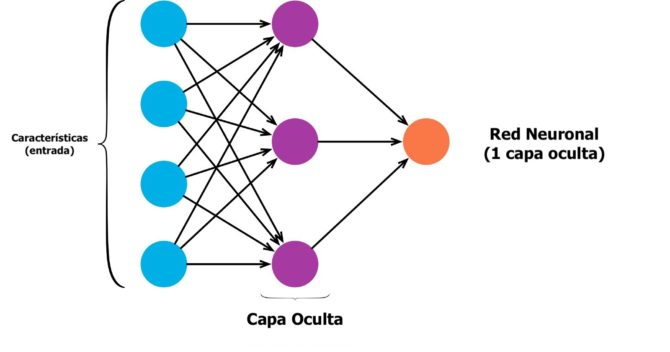


**Notas:**
*  la ultima capa es una sola neurona ya que el resultado es binario (1 o 0), pero si tiene varias categorías, debe usar varios neuronas para cada categoría.
*  Puede tener tantas capas ocultas como desee. De hecho, una red neuronal con más de una capa oculta se considera una red neuronal profunda.
*  el peso de cada neurona se calcula en el entrenamiento y comienza con la inicialización de los pesos con valores aleatorios y luego se entrenan con un método llamado backpropagation.
*   Esto se hace utilizando métodos de optimización como el descenso de gradiente para reducir el error entre la salida calculada y la deseada (también llamada salida objetivo)...el mejor es ADAM
*   Para calcular El error está determinado por una función de pérdida cuya pérdida queremos minimizar con el optimizador. en este tutorial solo necesitará la función de pérdida de entropía cruzada binaria que se usa para los problemas de clasificación binaria.


##Usando KERAS

---

Usaremos un modelo secuencial que es una pila lineal de capas, donde puede usar la gran variedad de capas disponibles en Keras. La capa más común es la capa Densa, que es su capa de red neuronal densamente conectada con todos los pesos y sesgos con los que ya está familiarizado

##P0.importando librerias

In [44]:
from keras.models import Sequential
from keras import layers

##P1.Creando modelo secuencial

---
*  1° capa tendremos doble capa 
*   - 1° # dimensiones (4085 columnas)
*   - 2° 10 neuronas
*   usaremos como activación RELU/Sigmoidal

In [45]:
input_dim = X_train.shape[1]  # Numero de características (neuronas de entrada)
print("neuronas de entrada (columnas del vector de entrenamiento):",input_dim)

NameError: ignored

In [46]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) #1° # dimensiones (4085 columnas), 2° 10 neuronas
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))  #que pasa si agregamos otra capa (mejorara?)
model.add(layers.Dense(1, activation='sigmoid'))

NameError: ignored

##P2. compilando el modelo.

---
Antes de que pueda comenzar con el entrenamiento del modelo, debe configurar el proceso de aprendizaje. Esto se hace con el método .compile().
*   Este método especifica el optimizador y la función de pérdida
*   agregamos una lista de métricas que luego se pueden usar para la evaluación (accuracy o Loss)


In [47]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

ValueError: ignored

##P3. entrenamos el modelo

In [48]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

NameError: ignored

##P4. viendo grafica de entrenamiento

In [40]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') # 

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento prec')
    plt.plot(x, val_acc, 'r', label='Validacion prec')
    plt.title('Precision Entrenamiento y validacion')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Perdida Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Perdida Validacion')
    plt.title('Perdida Entrenamiento y validacion')
    plt.legend()
    plt.show()

plot_history(history)

NameError: ignored

##P5.evaluar el modelo (presición)

In [41]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))

NameError: ignored

##P6. haciendo predicciones

In [42]:
oracion = ['estoy feliz con mi celular']
X_prueba = vectorizerNew.transform(oracion)  #convertimos la oración al array del bagword

#print('vector:',X_prueba[0].toarray())
predict=model.predict(X_prueba)
print(oracion,', El sentimiento es :',predict)

NameError: ignored

##P7. Exportar modelo y vocabulario


In [43]:
model.save('PLN_SENTIMIENTOS.h5');

NameError: ignored